In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195819 sha256=18ec5faa87a0dbf2ecd77272de4370a1898d935c54b5e670cf3fb4b23a839031
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [ ]:
import pandas as pd
from collections import defaultdict
from surprise import KNNWithMeans
from surprise import SVD, SVDpp
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt

#Cleaning and filtering the data

In [ ]:
df = pd.read_csv('ratings_Electronics.csv', header=0,
                 names = ['UserId', 'ProductId', 'Rating', 'Timestamp'])

In [ ]:
df.head()

,UserId,ProductId,Rating,Timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
1,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
2,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
3,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09
4,A1QGNMC6O1VW39,0511189877,5.0,1.397434e+09


In [ ]:
print('Total Number of rows :', df.shape[0])
print('Total Number of columns :', df.shape[1])

Total Number of rows : 7824481
Total Number of columns : 4


In [ ]:
df.dtypes

UserId        object
ProductId     object
Rating       float64
Timestamp    float64
dtype: object

In [ ]:
# drop missing values
print(df.isnull().sum())

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64


In [ ]:
# drop duplicates
df.duplicated().sum()

0

#Finding user ratings count threshold

In [ ]:
test_user = [10, 15 , 20, 25, 30, 35, 40, 45, 50]
accuracies =[]
best_params = []

for t in test_user:
  # filtering
  # taking only users who have given more than 30 ratings
  df_copy = df.copy()
  users_counts = df_copy['UserId'].value_counts().rename('users_counts')
  users_data   = df_copy.merge(users_counts,left_on='UserId',right_index=True)
  df_filtered = users_data[users_data.users_counts >= t]


  # taking only products which have received 10 or more ratings
  rating_counts = df_filtered['ProductId'].value_counts().rename('rating_counts')
  product_rating_data   = df_filtered.merge(rating_counts,left_on='ProductId',right_index=True)
  df_filtered_final = product_rating_data[product_rating_data.rating_counts >= 10]


  data = df_filtered_final.drop(['users_counts', 'rating_counts'], axis=1)

  reader = Reader(rating_scale=(1, 5))
  surprise_data = Dataset.load_from_df(data[['UserId', 'ProductId', 'Rating']], reader)
  trainset, testset = train_test_split(surprise_data, test_size=.30, random_state=7)

  svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.007, 0.009, 0.01], 'reg_all': [0.4, 0.6]}

  svd_gs = RandomizedSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
  #GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
  #svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)

  svd_gs.fit(surprise_data)
  #svdpp_gs.fit(surprise_data)

  # best RMSE score
  accuracies.append(svd_gs.best_score['rmse'])
  print(svd_gs.best_score['rmse'])
  #print(svdpp_gs.best_score['rmse'])

  # combination of parameters that gave the best RMSE score
  best_params.append(svd_gs.best_params['rmse'])
  print(svd_gs.best_params['rmse'])
  #print(svdpp_gs.best_params['rmse'])

1.0414056037318766
{'n_epochs': 25, 'lr_all': 0.007, 'reg_all': 0.4}
1.0057007165737393
{'n_epochs': 20, 'lr_all': 0.009, 'reg_all': 0.4}
0.9747930912945879
{'n_epochs': 25, 'lr_all': 0.007, 'reg_all': 0.4}
0.9476118473782742
{'n_epochs': 25, 'lr_all': 0.009, 'reg_all': 0.4}
0.9278294451400013
{'n_epochs': 25, 'lr_all': 0.009, 'reg_all': 0.4}
0.910665137356031
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
0.8976015470728427
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
0.8865481831057067
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
0.8699114959374074
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}


Text(0.5, 1.0, 'User ratings count threshold vs RMSE')

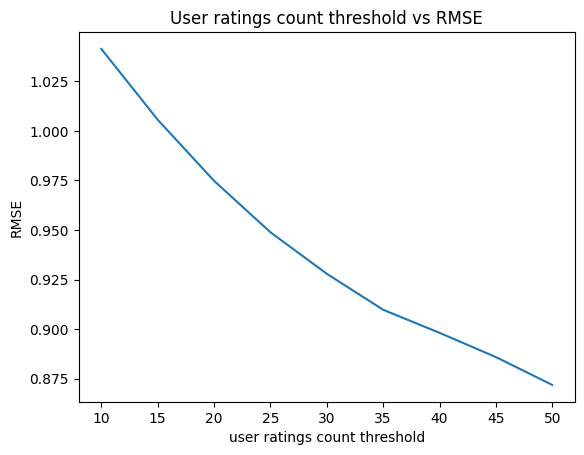

In [ ]:
plt.plot(test_user, accuracies)
plt.xlabel('user ratings count threshold')
plt.ylabel('RMSE')
plt.title('User ratings count threshold vs RMSE')

#Finding product ratings count threshold

In [ ]:
test_product = [5, 10 , 15, 20]
rmse =[]
best_params2 = []

for t in test_product:
  # filtering
  # taking only users who have given more than 30 ratings
  df_copy = df.copy()
  users_counts = df_copy['UserId'].value_counts().rename('users_counts')
  users_data   = df_copy.merge(users_counts,left_on='UserId',right_index=True)
  df_filtered = users_data[users_data.users_counts >= 50]


  # taking only products which have received 10 or more ratings
  rating_counts = df_filtered['ProductId'].value_counts().rename('rating_counts')
  product_rating_data   = df_filtered.merge(rating_counts,left_on='ProductId',right_index=True)
  df_filtered_final = product_rating_data[product_rating_data.rating_counts >= t]


  data = df_filtered_final.drop(['users_counts', 'rating_counts'], axis=1)

  reader = Reader(rating_scale=(1, 5))
  surprise_data = Dataset.load_from_df(data[['UserId', 'ProductId', 'Rating']], reader)
  trainset, testset = train_test_split(surprise_data, test_size=.30, random_state=7)

  svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.007, 0.009, 0.01], 'reg_all': [0.4, 0.6]}

  svd_gs = RandomizedSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
  #GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
  #svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)

  svd_gs.fit(surprise_data)
  #svdpp_gs.fit(surprise_data)

  # best RMSE score
  rmse.append(svd_gs.best_score['rmse'])
  print(svd_gs.best_score['rmse'])
  #print(svdpp_gs.best_score['rmse'])

  # combination of parameters that gave the best RMSE score
  best_params2.append(svd_gs.best_params['rmse'])
  print(svd_gs.best_params['rmse'])
  #print(svdpp_gs.best_params['rmse'])

0.894169195239771
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
0.8709595872049098
{'n_epochs': 25, 'lr_all': 0.009, 'reg_all': 0.4}
0.8568366142208992
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
0.8522008752989259
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Text(0.5, 1.0, 'Product ratings count threshold vs RMSE')

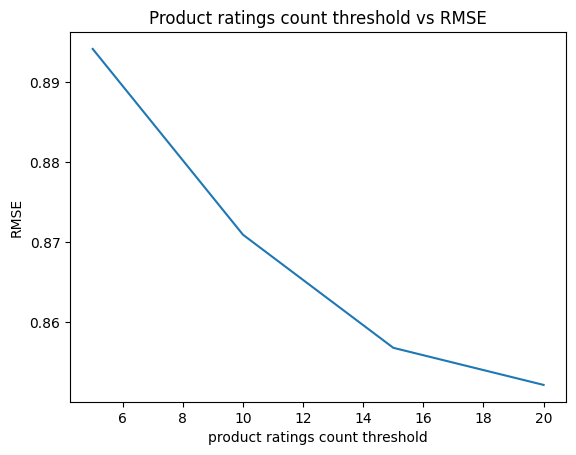

In [ ]:
plt.plot(test_product, rmse)
plt.xlabel('product ratings count threshold')
plt.ylabel('RMSE')
plt.title('Product ratings count threshold vs RMSE')

In [ ]:
# filtering
# taking only users who have given more than 30 ratings
users_counts = df['UserId'].value_counts().rename('users_counts')
users_data   = df.merge(users_counts,left_on='UserId',right_index=True)
df_filtered = users_data[users_data.users_counts >= 50]


# taking only products which have received 10 or more ratings
rating_counts = df_filtered['ProductId'].value_counts().rename('rating_counts')
product_rating_data   = df_filtered.merge(rating_counts,left_on='ProductId',right_index=True)
df_filtered_final = product_rating_data[product_rating_data.rating_counts >= 15]


data = df_filtered_final.drop(['users_counts', 'rating_counts'], axis=1)

In [ ]:
data.shape

(33830, 4)

In [ ]:
data.head()

,UserId,ProductId,Rating,Timestamp
1141327,A17HMM1M7T9PJ1,B000LRMS66,3.0,1.266019e+09
1133863,A1T1YSCDW0PD25,B000LRMS66,5.0,1.237507e+09
1140490,A6FIAB28IS79,B000LRMS66,4.0,1.197158e+09
1134091,A2HMF8ZR67BNZS,B000LRMS66,5.0,1.248998e+09
1141505,A1F9Z42CFF9IAY,B000LRMS66,5.0,1.208304e+09




#Training



#SVD model


In [ ]:
# train-test split
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(data[['UserId', 'ProductId', 'Rating']], reader)
trainset, testset = train_test_split(surprise_data, test_size=.30, random_state=7)

In [ ]:
svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.007, 0.009, 0.01], 'reg_all': [0.4, 0.6]}

svd_gs = RandomizedSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
#GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
#svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)

svd_gs.fit(surprise_data)
#svdpp_gs.fit(surprise_data)

# best RMSE score
print(svd_gs.best_score['rmse'])
#print(svdpp_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svd_gs.best_params['rmse'])
#print(svdpp_gs.best_params['rmse'])

0.8549414927665844
{'n_epochs': 25, 'lr_all': 0.009, 'reg_all': 0.4}


In [ ]:
import time 

start_time = time.time()

# Creating Model using best parameters
svd_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.2)

# Training the algorithm on the trainset
svd_model.fit(trainset)


# Predicting for test set
predictions_svd = svd_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVD on 5 split(s) by cross validation
svd_cv = cross_validate(svd_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
svd_df = pd.DataFrame.from_dict(svd_cv)
svd_described = svd_df.describe()
cv_results = pd.DataFrame([['SVD', svd_described['test_rmse']['mean'], svd_described['test_mae']['mean'], 
                           svd_described['fit_time']['mean'], svd_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svd, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8728  0.8695  0.8429  0.8456  0.8634  0.8589  0.0123  
MAE (testset)     0.6341  0.6365  0.6229  0.6230  0.6319  0.6297  0.0057  
Fit time          0.37    0.40    0.38    0.38    0.38    0.38    0.01    
Test time         0.05    0.04    0.06    0.04    0.04    0.05    0.01    


==================== Model Evaluation ===============================
RMSE: 0.8680

 Computational Time : 3.330s


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.858865,0.629686,0.382623,0.048349


#KNN

In [ ]:
# filtering
# taking only users who have given more than 30 ratings
users_counts = df['UserId'].value_counts().rename('users_counts')
users_data   = df.merge(users_counts,left_on='UserId',right_index=True)
df_filtered = users_data[users_data.users_counts >= 50]


# taking only products which have received 10 or more ratings
rating_counts = df_filtered['ProductId'].value_counts().rename('rating_counts')
product_rating_data   = df_filtered.merge(rating_counts,left_on='ProductId',right_index=True)
df_filtered_final = product_rating_data[product_rating_data.rating_counts >= 15]


data = df_filtered_final.drop(['users_counts', 'rating_counts'], axis=1)

In [ ]:
# train-test split
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(data[['UserId', 'ProductId', 'Rating']], reader)
trainset, testset = train_test_split(surprise_data, test_size=.30, random_state=7)

In [ ]:
from surprise.model_selection import RandomizedSearchCV
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans, KNNWithZScore

In [ ]:
knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [15, 20, 25, 30, 40, 50, 60],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline']}
              }

knnbasic_rs = RandomizedSearchCV(KNNBasic, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_rs = RandomizedSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnz_rs     = RandomizedSearchCV(KNNWithZScore, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)


knnbasic_rs.fit(surprise_data)
knnmeans_rs.fit(surprise_data)
knnz_rs.fit(surprise_data)

# best RMSE score
print(knnbasic_rs.best_score['rmse'])
print(knnmeans_rs.best_score['rmse'])
print(knnz_rs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(knnbasic_rs.best_params['rmse'])
print(knnmeans_rs.best_params['rmse'])
print(knnz_rs.best_params['rmse'])

0.9343240353011077
0.8944727331943818
0.905923815167386
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 30, 'sim_options': {'name': 'cosine', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 2}, 'k': 40, 'sim_options': {'name': 'cosine', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 2}, 'k': 50, 'sim_options': {'name': 'cosine', 'user_based': True}}


In [ ]:
cv_knn = pd.DataFrame()

In [ ]:
# Creating Model using best parameters
knnBasic_model = KNNBasic(bsl_options = {'method': 'als', 'reg': 1}, k=30, sim_options={'name': 'cosine', 'user_based': True})

# Training the algorithm on the trainset
knnBasic_model.fit(trainset)

# Predicting for test set
prediction_knnBasic = knnBasic_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s)
knnBasic_cv = cross_validate(knnBasic_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnBasic_df = pd.DataFrame.from_dict(knnBasic_cv)
knnBasic_described = knnBasic_df.describe()
knnBasic_cv_results = pd.DataFrame([['KNNBasic', knnBasic_described['test_rmse']['mean'], knnBasic_described['test_mae']['mean'], 
                           knnBasic_described['fit_time']['mean'], knnBasic_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_knn = cv_knn.append(knnBasic_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnBasic, verbose=True)
print("=====================================================================")

cv_knn

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9144  0.9418  0.9479  0.9005  0.9537  0.9317  0.0206  
MAE (testset)     0.6547  0.6735  0.6780  0.6505  0.6798  0.6673  0.0123  
Fit time          0.09    0.09    0.10    0.09    0.09    0.09    0.00    
Test time         0.28    0.29    0.27    0.29    0.28    0.28    0.01    


==================== Model Evaluation ===============================
RMSE: 0.9712


<ipython-input-30-95ade247caf2>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_knn = cv_knn.append(knnBasic_cv_results, ignore_index=True)


,Model,RMSE,MAE,Fit Time,Test Time
0,KNNBasic,0.931673,0.667306,0.092646,0.282793


In [ ]:
# Creating Model using best parameters
knnZscore_model = KNNWithZScore(bsl_options = {'method': 'als', 'reg': 2}, k=50, sim_options={'name': 'cosine', 'user_based': True})

# Training the algorithm on the trainset
knnZscore_model.fit(trainset)

# Predicting for testset
prediction_knnZscore = knnZscore_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s)
knnZscore_cv = cross_validate(knnZscore_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnZscore_df = pd.DataFrame.from_dict(knnZscore_cv)
knnZscore_described = knnZscore_df.describe()
knnZscore_cv_results = pd.DataFrame([['KNNWithZScore', knnZscore_described['test_rmse']['mean'], knnZscore_described['test_mae']['mean'], 
                           knnZscore_described['fit_time']['mean'], knnZscore_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_knn = cv_knn.append(knnZscore_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnZscore, verbose=True)
print("=====================================================================")

cv_knn

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8981  0.8948  0.9299  0.8999  0.9108  0.9067  0.0128  
MAE (testset)     0.6213  0.6184  0.6417  0.6191  0.6238  0.6249  0.0086  
Fit time          0.19    0.19    0.18    0.19    0.21    0.19    0.01    
Test time         0.36    0.36    0.33    0.35    0.38    0.36    0.02    


==================== Model Evaluation ===============================
RMSE: 0.9368


<ipython-input-31-b13fcae4f46e>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_knn = cv_knn.append(knnZscore_cv_results, ignore_index=True)


,Model,RMSE,MAE,Fit Time,Test Time
0,KNNBasic,0.931673,0.667306,0.092646,0.282793
1,KNNWithZScore,0.906680,0.624884,0.190490,0.356369


In [ ]:
# Creating Model using best parameters
knnMeansUU_model = KNNWithMeans(bsl_options = {'method': 'als', 'reg': 2}, k=40, sim_options={'name': 'cosine', 'user_based': True})

# Training the algorithm on the trainset
knnMeansUU_model.fit(trainset)

# Predicting for testset
prediction_knnMeansUU = knnMeansUU_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithMeans User-User on 5 split(s)
knnMeansUU_cv = cross_validate(knnMeansUU_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnMeansUU_df = pd.DataFrame.from_dict(knnMeansUU_cv)
knnMeansUU_described = knnMeansUU_df.describe()
knnMeansUU_cv_results = pd.DataFrame([['KNNWithMeans User-User', knnMeansUU_described['test_rmse']['mean'], knnMeansUU_described['test_mae']['mean'], 
                           knnMeansUU_described['fit_time']['mean'], knnMeansUU_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_knn = cv_knn.append(knnMeansUU_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnMeansUU, verbose=True)
print("=====================================================================")

cv_knn

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8817  0.9002  0.8990  0.8951  0.9046  0.8961  0.0078  
MAE (testset)     0.6216  0.6280  0.6256  0.6203  0.6299  0.6251  0.0037  
Fit time          0.12    0.13    0.12    0.11    0.12    0.12    0.01    
Test time         0.30    0.32    0.29    0.29    0.29    0.30    0.01    


==================== Model Evaluation ===============================
RMSE: 0.9304


<ipython-input-32-8409557d39d4>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_knn = cv_knn.append(knnMeansUU_cv_results, ignore_index=True)


,Model,RMSE,MAE,Fit Time,Test Time
0,KNNBasic,0.931673,0.667306,0.092646,0.282793
1,KNNWithZScore,0.906680,0.624884,0.190490,0.356369
2,KNNWithMeans User-User,0.896105,0.625106,0.119678,0.296670


In [ ]:
# Creating Model using best parameters
knnMeansII_model = KNNWithMeans(bsl_options = {'method': 'als', 'reg': 2}, k=40, sim_options={'name': 'cosine', 'user_based': True})

# Training the algorithm on the trainset
knnMeansII_model.fit(trainset)

# Predicting for testset
prediction_knnMeansII = knnMeansII_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithMeans Item-Item on 5 split(s)
knnMeansII_cv = cross_validate(knnMeansII_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnMeansII_df = pd.DataFrame.from_dict(knnMeansII_cv)
knnMeansII_described = knnMeansII_df.describe()
knnMeansII_cv_results = pd.DataFrame([['KNNWithMeans Item-Item', knnMeansII_described['test_rmse']['mean'], knnMeansII_described['test_mae']['mean'], 
                           knnMeansII_described['fit_time']['mean'], knnMeansII_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_knn = cv_knn.append(knnMeansII_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnMeansII, verbose=True)
print("=====================================================================")

cv_knn

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8991  0.8924  0.8838  0.8805  0.9179  0.8948  0.0133  
MAE (testset)     0.6262  0.6268  0.6198  0.6148  0.6344  0.6244  0.0067  
Fit time          0.12    0.14    0.12    0.12    0.12    0.12    0.01    
Test time         0.32    0.30    0.30    1.10    0.29    0.46    0.32    


==================== Model Evaluation ===============================
RMSE: 0.9304


<ipython-input-33-39a173cdfabe>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_knn = cv_knn.append(knnMeansII_cv_results, ignore_index=True)


,Model,RMSE,MAE,Fit Time,Test Time
0,KNNBasic,0.931673,0.667306,0.092646,0.282793
1,KNNWithZScore,0.906680,0.624884,0.190490,0.356369
2,KNNWithMeans User-User,0.896105,0.625106,0.119678,0.296670
3,KNNWithMeans Item-Item,0.894759,0.624393,0.122886,0.461556


KNN using Timestamp


In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler

# filtering
# taking only users who have given more than 30 ratings
users_counts = df['UserId'].value_counts().rename('users_counts')
users_data   = df.merge(users_counts,left_on='UserId',right_index=True)
df_filtered = users_data[users_data.users_counts >= 50]


# taking only products which have received 10 or more ratings
rating_counts = df_filtered['ProductId'].value_counts().rename('rating_counts')
product_rating_data   = df_filtered.merge(rating_counts,left_on='ProductId',right_index=True)
df_filtered_final = product_rating_data[product_rating_data.rating_counts >= 15]


data = df_filtered_final.drop(['users_counts', 'rating_counts'], axis=1)

# convert UserId and ProductId columns to numeric values
data['UserId'] = pd.factorize(data['UserId'])[0]
data['ProductId'] = pd.factorize(data['ProductId'])[0]

# preprocess the timestamp values
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
data['Year'] = data['Timestamp'].dt.year
data['Month'] = data['Timestamp'].dt.month
data['Day'] = data['Timestamp'].dt.day
data['Hour'] = data['Timestamp'].dt.hour
data['Minute'] = data['Timestamp'].dt.minute
data['Second'] = data['Timestamp'].dt.second
data = data.drop(['Timestamp'], axis=1)

# feature engineering
user_rating_mean = data.groupby('UserId')['Rating'].mean()
data['user_rating_mean'] = data['UserId'].apply(lambda x: user_rating_mean[x])
product_rating_mean = data.groupby('ProductId')['Rating'].mean()
data['product_rating_mean'] = data['ProductId'].apply(lambda x: product_rating_mean[x])
user_rating_count = data.groupby('UserId')['Rating'].count()
data['user_rating_count'] = data['UserId'].apply(lambda x: user_rating_count[x])
product_rating_count = data.groupby('ProductId')['Rating'].count()
data['product_rating_count'] = data['ProductId'].apply(lambda x: product_rating_count[x])

# define the features and target variables
X = data[['UserId', 'ProductId', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'user_rating_mean', 'product_rating_mean', 'user_rating_count', 'product_rating_count']]
y = data['Rating']

# normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# define the hyperparameter space
param_dist = {
    'n_neighbors': [15, 20, 25, 30, 40, 50, 60],
    'weights': ['uniform'],
    'metric': ['euclidean', 'manhattan', 'minkowski','cosine'],
    'p': [1, 2, 3],
}

# create a KNN regressor
knn = KNeighborsRegressor()

# perform a random search to find the best hyperparameters
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=20, cv=5, n_jobs=5)
random_search.fit(X, y)

# get the best hyperparameters
best_params = random_search.best_params_

print(best_params)


{'weights': 'uniform', 'p': 2, 'n_neighbors': 60, 'metric': 'euclidean'}


In [ ]:
# create a new KNN regressor with the best hyperparameters
knn = KNeighborsRegressor(**best_params)

# fit the model to the data
knn.fit(X, y)

# predict the ratings for all users and products in the data
y_pred = knn.predict(X)

# compute the root mean squared error
rmse = mean_squared_error(y, y_pred, squared=False)

# print the RMSE
print(best_params)
print(f'RMSE: {rmse:.4f}')

{'weights': 'uniform', 'p': 2, 'n_neighbors': 60, 'metric': 'euclidean'}
RMSE: 0.7878
